In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma, scoreatpercentile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score

In [2]:
# Load the claims data file into a DataFrame 
file_path = "claim_data_group4_2024.csv"
claims_data_df = pd.read_csv(file_path)
claims_data_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [3]:
# Claim frequency will be used instead for number of claims as the period of exposure, meaning, the time a claim can occur, is also considered.
# Claim severity is the average claim amount per claim and will be used instead of the claim amount. 
claims_data_df['Frequency'] = claims_data_df['ClaimNb'] / claims_data_df['Exposure'] #Number of claims per year
claims_data_df['Severity'] = claims_data_df['ClaimAmount'] / claims_data_df['ClaimNb'] #Amount per claim

# Drop the original columns and place the new columns at the same position as the original columns 
claims_data = claims_data_df.drop(columns=['ClaimNb'])
#claims_data = claims_data[['Frequency','Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'Severity']]

# Fill missing values in the 'Severity' column with 0 (meaning no claim occurred)
claims_data['Severity'] = claims_data['Severity'].fillna(0)

*Catégorisation des variables using the quintile function*

In [4]:
# Function to perform quantile binning 
def quantile_binning_and_apply(claims_data, features, n_bins, specific_bins=None):
    bin_labels_dict = {}
    for feature in features:
        # Utiliser un nombre de bins spécifique si fourni, sinon utiliser n_bins
        bins = specific_bins.get(feature, n_bins) if specific_bins else n_bins
        bin_edges = pd.qcut(claims_data[feature], q=bins, retbins=True, duplicates='drop')[1]
        bin_edges[-1] += 1e-5
        labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
        claims_data[f'Binned {feature}'] = pd.cut(claims_data[feature], bins=bin_edges, labels=labels, include_lowest=True, duplicates='drop')
        bin_labels_dict[f'Binned {feature}'] = labels
        print(f'Labels for {feature}: {labels}')
    return bin_labels_dict

# Treatment of BonusMalus
claims_data['Binned BonusMalus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

In [5]:
# List of features to bin 
features = ['DrivAge', 'VehAge','VehPower']
n_bins = 10

# Définir un nombre de bins spécifique pour DrivAge
specific_bins = {'DrivAge': 20}  # Par exemple, 30 bins pour DrivAge pour plus de granularité

# Call the function
bin_labels_dict = quantile_binning_and_apply(claims_data, features, n_bins, specific_bins)

Labels for DrivAge: ['18.0-25.0', '25.0-28.0', '28.0-30.0', '30.0-32.0', '32.0-34.0', '34.0-36.0', '36.0-38.0', '38.0-40.0', '40.0-42.0', '42.0-44.0', '44.0-46.0', '46.0-48.0', '48.0-51.0', '51.0-53.0', '53.0-55.0', '55.0-57.0', '57.0-61.0', '61.0-65.0', '65.0-72.0', '72.0-99.0']
Labels for VehAge: ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-15.0', '15.0-100.0']
Labels for VehPower: ['4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0', '8.0-9.0', '9.0-15.0']


# Clustering using a different approach

In [6]:
from sklearn.cluster import DBSCAN

# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus'] # See if we add more columns to improve the clustering results 

# Prepare data for categorical columns 
# Combine binned features and additional categorical columns
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns

# Convert categorical columns to category type
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering
df_categorical = claims_data[categorical_columns]

# Encodage one-hot des caractéristiques catégorielles
encoder = OneHotEncoder()
df_categorical_encoded = encoder.fit_transform(df_categorical)

# Standardiser les données pour DBSCAN
scaler = StandardScaler()
df_categorical_scaled = scaler.fit_transform(df_categorical_encoded.toarray())

# Appliquer DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=3)
clusters = dbscan.fit_predict(df_categorical_scaled)

# Ajouter les clusters prédits aux données
claims_data['Predicted Risk Cluster'] = clusters

# Évaluation des clusters
silhouette = silhouette_score(df_categorical_scaled, claims_data['Predicted Risk Cluster'])
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.6128297479808472


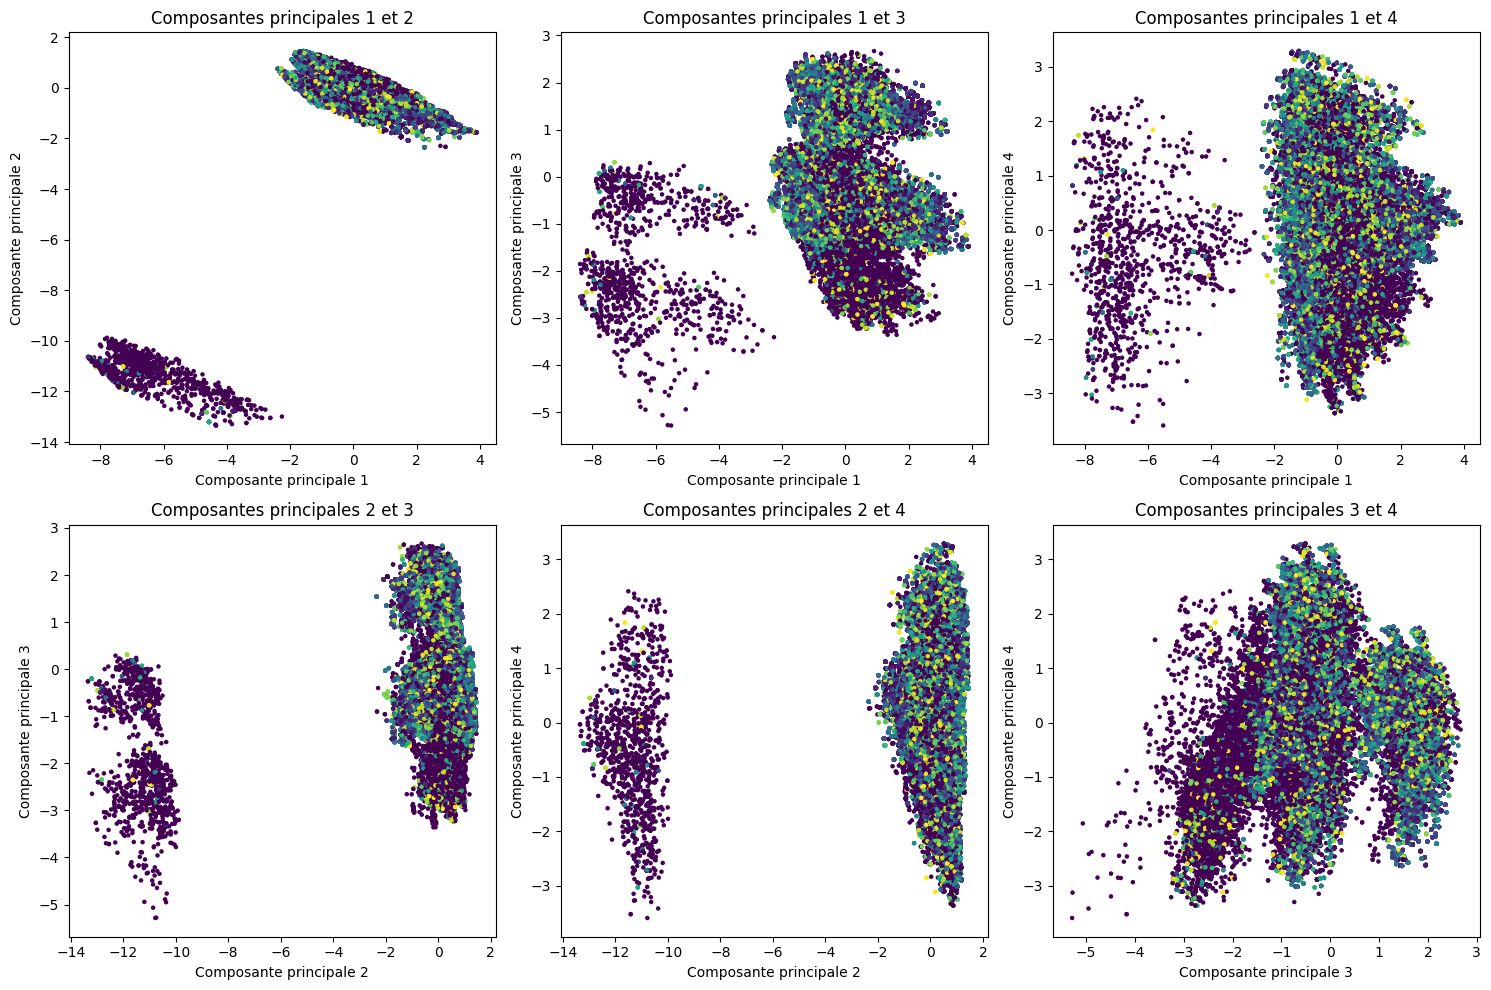

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduction de la dimensionnalité avec PCA
pca = PCA(n_components=5)  # Réduire à 5 dimensions pour conserver plus d'informations
df_categorical_pca = pca.fit_transform(df_categorical_scaled)

# Visualisation des clusters DBSCAN après réduction de la dimensionnalité
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Liste des paires de composantes principales à visualiser
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for i, (comp1, comp2) in enumerate(pairs):
    ax = axes[i // 3, i % 3]
    ax.scatter(df_categorical_pca[:, comp1], df_categorical_pca[:, comp2], c=clusters, cmap='viridis', s=5)
    ax.set_title(f'Composantes principales {comp1+1} et {comp2+1}')
    ax.set_xlabel(f'Composante principale {comp1+1}')
    ax.set_ylabel(f'Composante principale {comp2+1}')

plt.tight_layout()
plt.show()

*Determining the optimal amount of clusters*

([<matplotlib.axis.XTick at 0x356f3a510>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

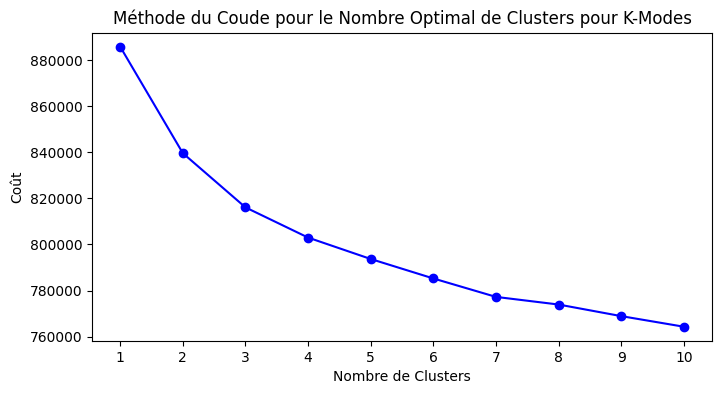

In [8]:
# Colonnes catégorielles supplémentaires
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus']

# Préparer les données pour l'encodage one-hot
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Utiliser uniquement les colonnes catégorielles pour le clustering
df_categorical = claims_data[categorical_columns]

# Combiner les résultats du PCA avec les colonnes catégorielles
df_categorical_pca_df = pd.DataFrame(df_categorical_pca, columns=[f'PCA{i+1}' for i in range(df_categorical_pca.shape[1])])
combined_df = pd.concat([df_categorical_pca_df, df_categorical], axis=1)

# Convertir le DataFrame combiné en une matrice numpy avant d'appliquer K-Modes
data_matrix = combined_df.to_numpy()

# Appliquer la méthode du coude pour trouver le nombre optimal de clusters pour K-Modes
cost = []
K = range(1, 11)  # Plage de clusters à essayer
for num_clusters in K:
    kmodes = KModes(n_clusters=num_clusters, random_state=42)
    clusters = kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Tracer le graphique du coude
plt.figure(figsize=(8, 4))
plt.plot(K, cost, marker='o', color='b')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Coût')
plt.title('Méthode du Coude pour le Nombre Optimal de Clusters pour K-Modes')
plt.xticks(K)

Score de silhouette pour les clusters K-Means : 0.26977786419851235


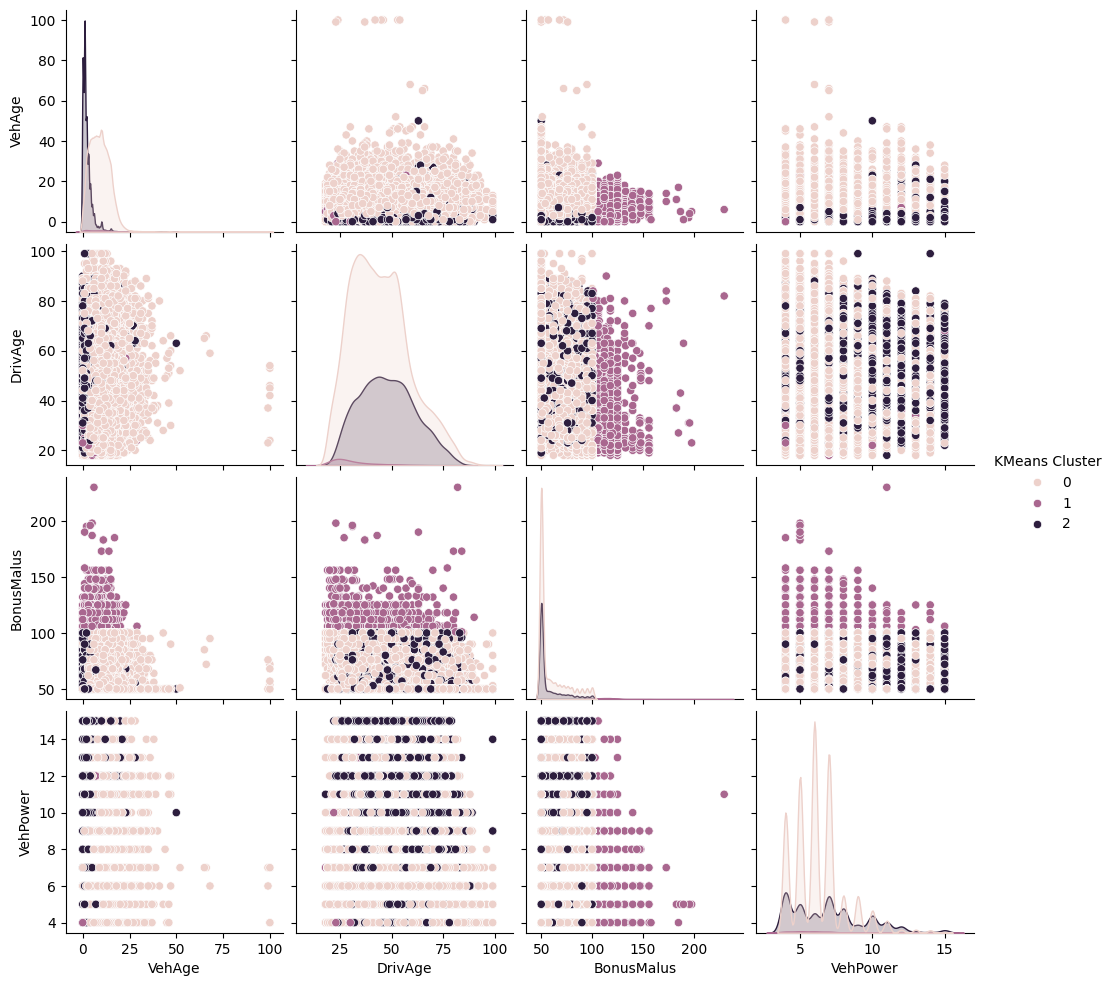

In [9]:
from sklearn.cluster import KMeans

# Appliquer K-Means sur les clusters DBSCAN
kmeans = KMeans(n_clusters=3, random_state=42)  # Spécifier le nombre de clusters souhaité
kmeans_clusters = kmeans.fit_predict(df_categorical_pca)

# Calculer le score de silhouette pour les clusters K-Means
silhouette = silhouette_score(df_categorical_pca, kmeans_clusters)
print(f"Score de silhouette pour les clusters K-Means : {silhouette}")

# Ajouter les clusters K-Means aux données
claims_data['KMeans Cluster'] = kmeans_clusters

# Visualisation des clusters K-Means
sns.pairplot(claims_data, hue='KMeans Cluster', vars=['VehAge', 'DrivAge', 'BonusMalus', 'VehPower'])
plt.show()

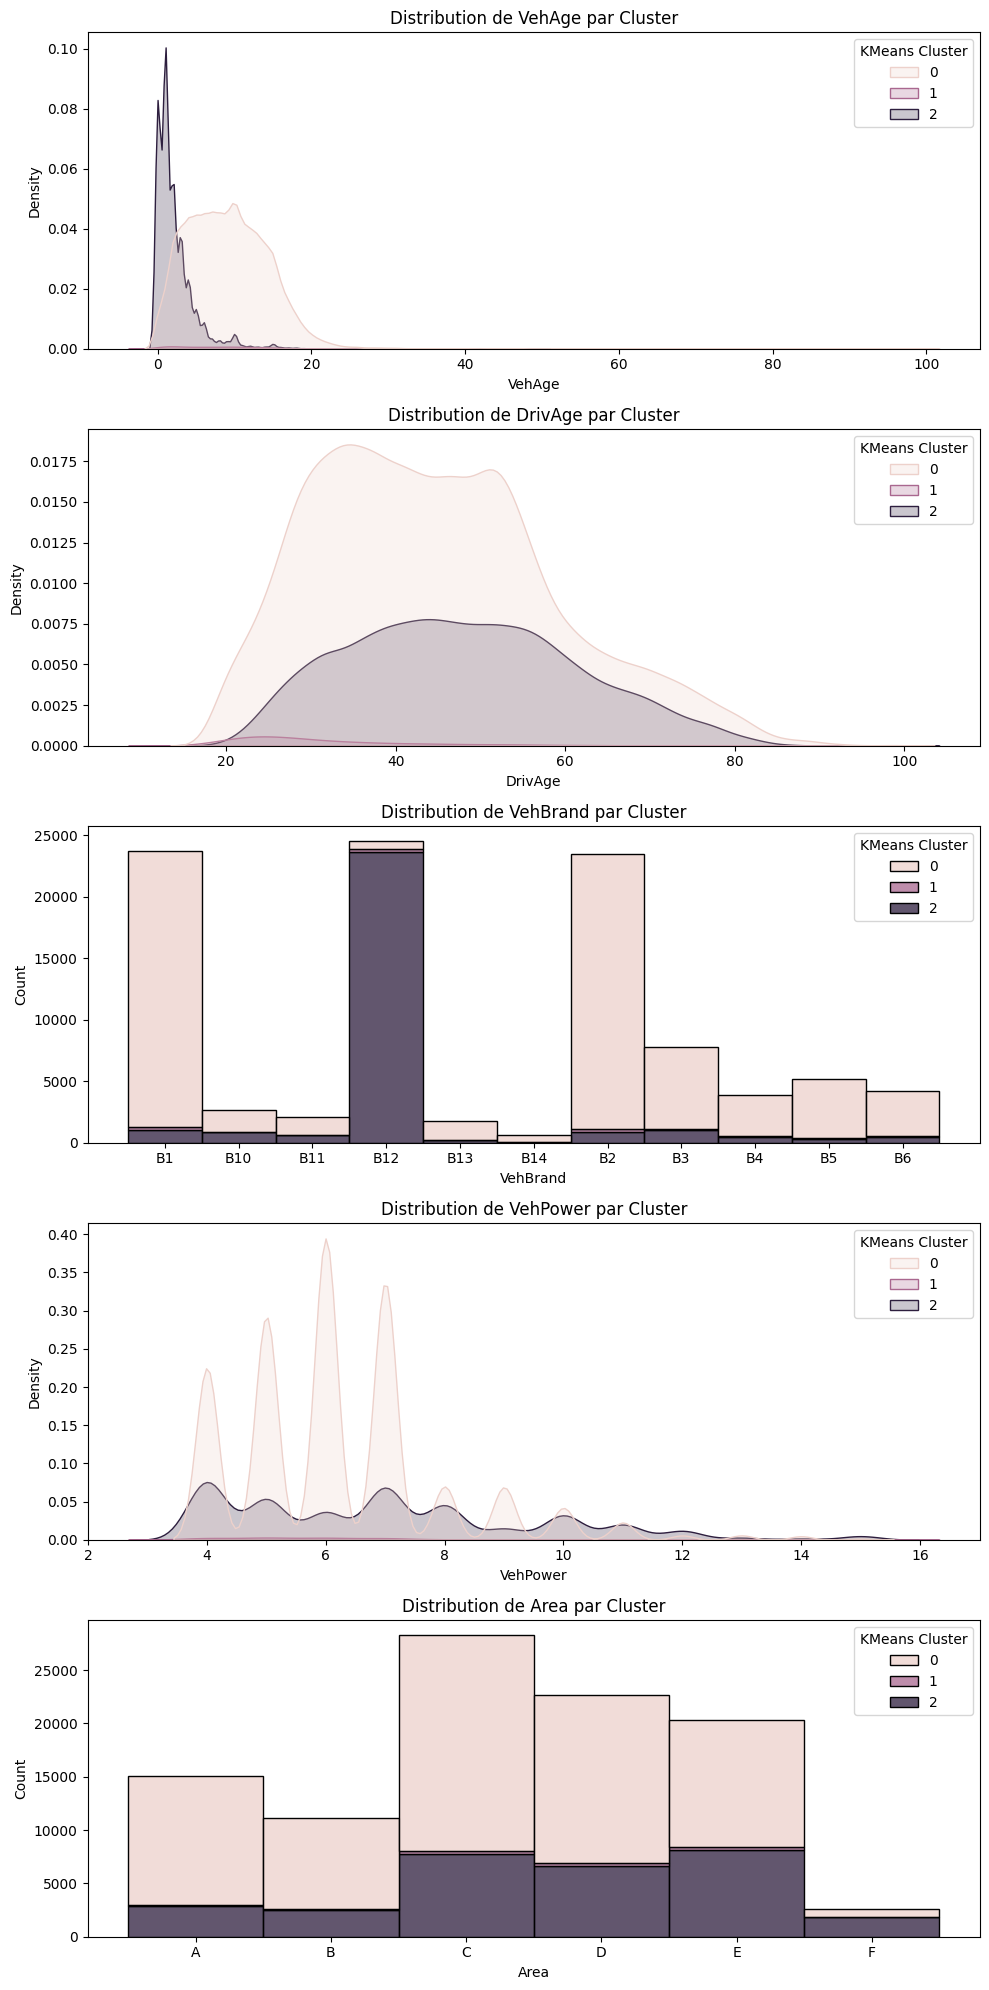

In [37]:
# Define the variables to plot 
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area']
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 20))

# Plot the distribution of variables by predicted risk cluster
# We use sns.histplot for categorical variables and sns.kdeplot for numerical variables.
# This allows us to visualize how different variables are distributed across the predicted risk clusters.
for i, var in enumerate(variables):
    assert var in claims_data.columns, f"La colonne {var} est manquante dans claims_data"
    if claims_data[var].dtype.name == 'category' or claims_data[var].dtype.name == 'object':
        sns.histplot(data=claims_data, x=var, hue='KMeans Cluster', multiple="stack", ax=axes[i])
    else:
        sns.kdeplot(data=claims_data, x=var, hue='KMeans Cluster', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {var} par Cluster')

# Adjust the layout of the subplots to avoid overlap 
plt.tight_layout()
plt.show()

In [10]:
# Count the number of data points in each cluster predicted by the K-Modes model
predicted_cluster_counts = claims_data['KMeans Cluster'].value_counts()
print("Number of data points in each predicted cluster:")
print(predicted_cluster_counts)

# Function to get the most frequent values (mode) for each feature in each cluster
def get_cluster_modes(df, cluster_col, feature_cols):
    cluster_modes = df.groupby(cluster_col)[feature_cols].agg(lambda x: x.mode().iloc[0])
    return cluster_modes

# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand', 'Binned BonusMalus']

# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(claims_data, 'KMeans Cluster', feature_cols)

# Display common characteristics for each cluster
cluster_modes

Number of data points in each predicted cluster:
KMeans Cluster
0    69220
2    29638
1     1142
Name: count, dtype: int64


,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Binned BonusMalus
KMeans Cluster,,,,,,
0,48.0-51.0,12.0-15.0,4.0-5.0,C,B1,Bonus
1,18.0-25.0,0.0-1.0,4.0-5.0,D,B12,Malus
2,57.0-61.0,0.0-1.0,4.0-5.0,E,B12,Bonus


In [11]:
# Create DataFrames based on clusters for further analysis (premium calculation, etc.)
df_cluster_0 = claims_data[claims_data['KMeans Cluster'] == 0].copy()
df_cluster_1 = claims_data[claims_data['KMeans Cluster'] == 1].copy()
df_cluster_2 = claims_data[claims_data['KMeans Cluster'] == 2].copy()

In [12]:
# Fonctions de calcul de l'AIC et du BIC comme mesures de la qualité de fitting des différents modèles de distribution
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

In [13]:
def distrib_test(x, dist, params, title, dist_type):
    """ Test distribution and calculate AIC and BIC. """
    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

In [14]:
def distrib_severity(x, dist, params, title, dist_type):
    """ Test distribution severity and calculate AIC and BIC. """
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

In [30]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['Frequency']
non_zero_claims = claims_data[claims_data['Severity'] > 0]['Severity']

In [31]:
# Poisson Distribution Fitting for Claim Frequency
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
distrib_test(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency
n_trials = 1  # Number of trials (1 for each policyholder) 
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
distrib_test(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency
mean_claims = np.mean(claim_counts)
var_claims = np.var(claim_counts, ddof=1) # Use ddof=1 for sample variance 
if var_claims > mean_claims:
    r_negbin = (mean_claims ** 2) / (var_claims - mean_claims)
    p_negbin = r_negbin / (r_negbin + mean_claims)
    params_negbin = [r_negbin, p_negbin]
    
    # Fit check with your distribution testing function
    distrib_test(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 133832.56732566294
BIC for Fit with Poisson Distribution: 133842.08025112792
AIC for Fit with Binomial Distribution: 141115.09246842703
BIC for Fit with Binomial Distribution: 141134.11831935696
AIC for Fit with Negative Binomial Distribution: 120200.78647043131
BIC for Fit with Negative Binomial Distribution: 120219.81232136126


In [32]:
# Log-normal fitting for severity 
shape, loc, scale = lognorm.fit(non_zero_claims)
params_lognorm = [shape, loc, scale]
distrib_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b, loc_pareto, scale_pareto = pareto.fit(non_zero_claims)  
params_pareto = [b, loc_pareto, scale_pareto]
distrib_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha, loc_gamma, beta = gamma.fit(non_zero_claims)  
params_gamma = [alpha, loc_gamma, beta]
distrib_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution', dist_type='continuous')


AIC for Fit with Log-normal Distribution: 61011.03355955744
BIC for Fit with Log-normal Distribution: 61029.653310400405
AIC for Fit with Pareto Distribution: 61251.71150028282
BIC for Fit with Pareto Distribution: 61270.33125112578
AIC for Fit with Gamma Distribution: 167970.14982245426
BIC for Fit with Gamma Distribution: 167988.76957329724


In [33]:
# Monte carlo simulation for ALL CLAIMS (Entire Data Set)

np.random.seed(23) # Set seed for reproducibility

# Parameters
n_simulations = 100
n_policies = len(claims_data)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs = []

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once (Frequency per year per policy)
    frequency = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Create a severity matrix for policies with claims
    max_claim = frequency.max()  # Max number of claims across policies 
    severity_matrix = np.zeros((n_policies, max_claim))
    
    # Generate severities per policy based on the number of claims (frequency)
    for policy_idx in range(n_policies):
        claim_count = frequency[policy_idx]
        if claim_count > 0:
            severity_matrix[policy_idx, :claim_count] = lognorm.rvs(
                shape, loc=0, scale=scale, size=claim_count
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity = np.sum(severity_matrix, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df = pd.DataFrame({
        'Policy': np.arange(n_policies),
        'Frequency': frequency,
        'Premium_per_policy': Total_claim_severity,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs.append(temp_df)

# Concatenate all temporary DataFrames at once for better performance
simulation_results = pd.concat(simulation_dfs, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation = simulation_results.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium = premium_per_simulation.mean()
average_premium

200.9470920160547

In [15]:
# Filter out zero claim amounts for severity 
claim_counts_0 = df_cluster_0['Frequency']
non_zero_claims_0 = df_cluster_0[df_cluster_0['Severity'] > 0]['Severity']

In [16]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 0)
lambda_poisson_0 = np.mean(claim_counts_0)
params_poisson_0 = [lambda_poisson_0]
distrib_test(claim_counts_0, poisson, params_poisson_0, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 0)
n_trials_0 = 1  # Number of trials (1 for each policyholder)
p_success_0 = np.mean(claim_counts_0) / n_trials_0
params_binom_0 = [n_trials_0, p_success_0]
distrib_test(claim_counts_0, binom, params_binom_0, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 0)
mean_claims_0 = np.mean(claim_counts_0)
var_claims_0 = np.var(claim_counts_0, ddof=1)  # Use ddof=1 for sample variance
if var_claims_0 > mean_claims_0:
    r_negbin_0 = (mean_claims_0 ** 2) / (var_claims_0 - mean_claims_0)
    p_negbin_0 = r_negbin_0 / (r_negbin_0 + mean_claims_0)
    params_negbin_0 = [r_negbin_0, p_negbin_0]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_0, nbinom, params_negbin_0, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 93311.16800311534
BIC for Fit with Poisson Distribution: 93320.31304823252
AIC for Fit with Binomial Distribution: 98567.02420875787
BIC for Fit with Binomial Distribution: 98585.31429899225
AIC for Fit with Negative Binomial Distribution: 84582.39796882073
BIC for Fit with Negative Binomial Distribution: 84600.68805905512


In [17]:
# Log-normal fitting
shape_0, loc_0, scale_0 = lognorm.fit(non_zero_claims_0)
params_lognorm_0 = [shape_0, loc_0, scale_0]
distrib_severity(non_zero_claims_0, lognorm, params_lognorm_0, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_0, loc_pareto_0, scale_pareto_0 = pareto.fit(non_zero_claims_0)  
params_pareto_0 = [b_pareto_0, loc_pareto_0, scale_pareto_0]
distrib_severity(non_zero_claims_0, pareto, params_pareto_0, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_0, loc_gamme_0, beta_0 = gamma.fit(non_zero_claims_0)  
params_gamma_0 = [alpha_0, loc_gamme_0, beta_0]
distrib_severity(non_zero_claims_0, gamma, params_gamma_0, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 45605.48740586823
BIC for Fit with Log-normal Distribution: 45623.24110762722
AIC for Fit with Pareto Distribution: 45698.36417592401
BIC for Fit with Pareto Distribution: 45716.117877683
AIC for Fit with Gamma Distribution: 125766.14628310058
BIC for Fit with Gamma Distribution: 125783.89998485956


In [18]:
# Monte carlo simulation for cluster 0

np.random.seed(24) # Set seed for reproducibility

# Parameters
n_simulations_0 = 100
n_policies_0 = len(df_cluster_0)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_0 = []

# Monte Carlo simulation loop
for i in range(n_simulations_0):
    # Simulate number of claims for all policies at once (Frequency_0 per year per policy)
    frequency_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Create a severity matrix for policies with claims
    max_claim_0 = frequency_0.max()  # Max number of claims across policies for Cluster 0
    severity_matrix_0 = np.zeros((n_policies_0, max_claim_0))
    
    # Generate severities per policy based on the number of claims (frequency_0)
    for policy_idx in range(n_policies_0):
        claim_count_0 = frequency_0[policy_idx]
        if claim_count_0 > 0:
            severity_matrix_0[policy_idx, :claim_count_0] = lognorm.rvs(
                shape_0, loc=0, scale=scale_0, size=claim_count_0
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_0 = np.sum(severity_matrix_0, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_0 = pd.DataFrame({
        'Policy': np.arange(n_policies_0),
        'Frequency': frequency_0,
        'Premium_per_policy': Total_claim_severity_0,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_0.append(temp_df_0)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_0 = pd.concat(simulation_dfs_0, ignore_index=True)

# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_0 = simulation_results_0.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium_0 = premium_per_simulation_0.mean()
average_premium_0

203.48518067739064

In [19]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_0 = scoreatpercentile(simulation_results_0['Premium_per_policy'], 99.5)

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_0)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_0, otherwise 0
simulation_results_0['Hit_Test'] = simulation_results_0['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium_0 else 0)

# Step 3: Calculate the percentage of hits
total_hits_0 = simulation_results_0['Hit_Test'].sum()
total_records_0 = len(simulation_results_0)
hit_percentage_0 = (total_hits_0 / total_records_0) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage_0))

Adjusted Premium (99.5th percentile constraint): 10186.85054310081
Percentage of Hits (Total claims > adjusted premium): 0.50%


In [20]:
# Filter out zero claim amounts for severity 
claim_counts_1 = df_cluster_1['Frequency']
non_zero_claims_1 = df_cluster_1[df_cluster_1['Severity'] > 0]['Severity']

In [21]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 1)
lambda_poisson_1 = np.mean(claim_counts_1)
params_poisson_1 = [lambda_poisson_1]
distrib_test(claim_counts_1, poisson, params_poisson_1, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 1)
n_trials_1 = 1  # Number of trials (1 for each policyholder)
p_success_1 = np.mean(claim_counts_1) / n_trials_1
params_binom_1 = [n_trials_1, p_success_1]
distrib_test(claim_counts_1, binom, params_binom_1, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 1)
mean_claims_1 = np.mean(claim_counts_1)
var_claims_1 = np.var(claim_counts_1, ddof=1)  # Use ddof=1 for sample variance
if var_claims_1 > mean_claims_1:
    r_negbin_1 = (mean_claims_1 ** 2) / (var_claims_1 - mean_claims_1)
    p_negbin_1 = r_negbin_1 / (r_negbin_1 + mean_claims_1)
    params_negbin_1 = [r_negbin_1, p_negbin_1]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_1, nbinom, params_negbin_1, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 4980.9381926538545
BIC for Fit with Poisson Distribution: 4985.978729044071
AIC for Fit with Binomial Distribution: 5696.0118507246625
BIC for Fit with Binomial Distribution: 5706.092923505094
AIC for Fit with Negative Binomial Distribution: 4717.906303503491
BIC for Fit with Negative Binomial Distribution: 4727.9873762839225


In [22]:
# Log-normal fitting
shape_1, loc_1, scale_1 = lognorm.fit(non_zero_claims_1)
params_lognorm_1 = [shape_1, loc_1, scale_1]
distrib_severity(non_zero_claims_1, lognorm, params_lognorm_1, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_1, loc_pareto_1, scale_pareto_1 = pareto.fit(non_zero_claims_1)  
params_pareto_1 = [b_pareto_1, loc_pareto_1, scale_pareto_1]
distrib_severity(non_zero_claims_1, pareto, params_pareto_1, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_1, loc_gamma_1, beta_1 = gamma.fit(non_zero_claims_1) 
params_gamma_1 = [alpha_1, loc_gamma_1, beta_1]
distrib_severity(non_zero_claims_1, gamma, params_gamma_1, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 2630.087641049742
BIC for Fit with Log-normal Distribution: 2639.2563784657873
AIC for Fit with Pareto Distribution: 2672.849978736416
BIC for Fit with Pareto Distribution: 2682.018716152461
AIC for Fit with Gamma Distribution: 7138.077879049448
BIC for Fit with Gamma Distribution: 7147.2466164654925


In [23]:
# Monte carlo simulation for cluster 1

np.random.seed(25) # Set seed for reproducibility

# Parameters
n_simulations_1 = 100
n_policies_1 = len(df_cluster_1)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_1 = []

# Monte Carlo simulation loop
for i in range(n_simulations_1):
    # Simulate number of claims for all policies at once (Frequency_1 per year per policy)
    frequency_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Create a severity matrix for policies with claims
    max_claim_1 = frequency_1.max()  # Max number of claims across policies for cluster 1 
    severity_matrix_1 = np.zeros((n_policies_1, max_claim_1))
    
    # Generate severities per policy based on the number of claims (frequency_1)
    for policy_idx in range(n_policies_1):
        claim_count_1 = frequency_1[policy_idx]
        if claim_count_1 > 0:
            severity_matrix_1[policy_idx, :claim_count_1] = lognorm.rvs(
                shape_1, loc=0, scale=scale_1, size=claim_count_1
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_1 = np.sum(severity_matrix_1, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_1 = pd.DataFrame({
        'Policy': np.arange(n_policies_1),
        'Frequency': frequency_1,
        'Premium_per_policy': Total_claim_severity_1,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_1.append(temp_df_1)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_1 = pd.concat(simulation_dfs_1, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_1 = simulation_results_1.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium_1 = premium_per_simulation_1.mean()
average_premium_1

538.9815912653158

In [24]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_1 = scoreatpercentile(simulation_results_1['Premium_per_policy'], 99.5)

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_1)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_1, otherwise 0
simulation_results_1['Hit_Test'] = simulation_results_1['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium_1 else 0)

# Step 3: Calculate the percentage of hits
total_hits_1 = simulation_results_1['Hit_Test'].sum()
total_records_1 = len(simulation_results_1)
hit_percentage_1 = (total_hits_1 / total_records_1) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage_1))

Adjusted Premium (99.5th percentile constraint): 18396.59292304237
Percentage of Hits (Total claims > adjusted premium): 0.50%


In [25]:
# Filter out zero claim amounts for severity 
claim_counts_2 = df_cluster_2['Frequency']
non_zero_claims_2 = df_cluster_2[df_cluster_2['Severity'] > 0]['Severity']

In [26]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 2)
lambda_poisson_2 = np.mean(claim_counts_2)
params_poisson_2 = [lambda_poisson_2]
distrib_test(claim_counts_2, poisson, params_poisson_2, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 2)
n_trials_2 = 1  # Number of trials (1 for each policyholder)
p_success_2 = np.mean(claim_counts_2) / n_trials_2
params_binom_2 = [n_trials_2, p_success_2]
distrib_test(claim_counts_2, binom, params_binom_2, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 2)
mean_claims_2 = np.mean(claim_counts_2)
var_claims_2 = np.var(claim_counts_2, ddof=1)  # Use ddof=1 for sample variance
if var_claims_2 > mean_claims_2:
    r_negbin_2 = (mean_claims_2 ** 2) / (var_claims_2 - mean_claims_2)
    p_negbin_2 = r_negbin_2 / (r_negbin_2 + mean_claims_2)
    params_negbin_2 = [r_negbin_2, p_negbin_2]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_2, nbinom, params_negbin_2, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 35296.210971008026
BIC for Fit with Poisson Distribution: 35304.50778360877
AIC for Fit with Binomial Distribution: 36705.76268100254
BIC for Fit with Binomial Distribution: 36722.35630620404
AIC for Fit with Negative Binomial Distribution: 30397.47887974498
BIC for Fit with Negative Binomial Distribution: 30414.07250494648


In [27]:
# Log-normal fitting
shape_2, loc_2, scale_2 = lognorm.fit(non_zero_claims_2)
params_lognorm_2 = [shape_2, loc_2, scale_2]
distrib_severity(non_zero_claims_2, lognorm, params_lognorm_2, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_2, loc_pareto_2, scale_pareto_2 = pareto.fit(non_zero_claims_2) 
params_pareto_2 = [b_pareto_2, loc_pareto_2, scale_pareto_2]
distrib_severity(non_zero_claims_2, pareto, params_pareto_2, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_2, loc_gamma_2, beta_2 = gamma.fit(non_zero_claims_2) 
params_gamma_2 = [alpha_2, loc_gamma_2, beta_2]
distrib_severity(non_zero_claims_2, gamma, params_gamma_2, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 12735.349357875035
BIC for Fit with Log-normal Distribution: 12749.257197542094
AIC for Fit with Pareto Distribution: 12867.327922435043
BIC for Fit with Pareto Distribution: 12881.235762102102
AIC for Fit with Gamma Distribution: 34910.14154356486
BIC for Fit with Gamma Distribution: 34924.04938323192


In [28]:
# Monte carlo simulation for cluster 2

np.random.seed(26) # Set seed for reproducibility

# Parameters
n_simulations_2 = 100
n_policies_2 = len(df_cluster_2)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_2 = []

# Monte Carlo simulation loop
for i in range(n_simulations_2):
    # Simulate number of claims for all policies at once (Frequency_2 per year per policy)
    frequency_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Create a severity matrix for policies with claims
    max_claim_2 = frequency_2.max()  # Max number of claims across policies for cluster 2 
    severity_matrix_2 = np.zeros((n_policies_2, max_claim_2))
    
    # Generate severities per policy based on the number of claims (frequency_2)
    for policy_idx in range(n_policies_2):
        claim_count_2 = frequency_2[policy_idx]
        if claim_count_2 > 0:
            severity_matrix_2[policy_idx, :claim_count_2] = lognorm.rvs(
                shape_2, loc=0, scale=scale_2, size=claim_count_2
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_2 = np.sum(severity_matrix_2, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_2 = pd.DataFrame({
        'Policy': np.arange(n_policies_2),
        'Frequency': frequency_2,
        'Premium_per_policy': Total_claim_severity_2,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_2.append(temp_df_2)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_2 = pd.concat(simulation_dfs_2, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_2 = simulation_results_2.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium_2 = premium_per_simulation_2.mean()
average_premium_2

176.66325929595922

In [29]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_2 = scoreatpercentile(simulation_results_2['Premium_per_policy'], 99.5)

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_2)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_2, otherwise 0
simulation_results_2['Hit_Test'] = simulation_results_2['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium_2 else 0)

# Step 3: Calculate the percentage of hits
total_hits_2 = simulation_results_2['Hit_Test'].sum()
total_records_2 = len(simulation_results_2)
hit_percentage_2 = (total_hits_2 / total_records_2) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage_2))

Adjusted Premium (99.5th percentile constraint): 2802.8698123081836
Percentage of Hits (Total claims > adjusted premium): 0.50%
